<h1> 1. Context</h1>

In this chapter we will explore how a single transformer model called XLM-RoBERTa (introduced in Chapter 3) 1 can be fine-tuned to perform named entity recognition (NER) across several languages.

<h1>2. Prepare dataset </h1>

<h2> 2.1 Dataset Loading </h2>

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/131k [00:00<?, ?B/s]

XTREME has 183 configurations


In [ ]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
len(panx_subsets)

40

In [ ]:
#Load the German corpus subset
from datasets import load_dataset
ds = load_dataset("xtreme", name = 'PAN-X.de')

train-00000-of-00001.parquet:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/590k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/588k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
ds.keys()

dict_keys(['train', 'validation', 'test'])

In [ ]:
#Make a multi-lingual corpus
from collections import defaultdict
from datasets import DatasetDict

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]

panx_ch = defaultdict(DatasetDict)

#logic: load all the corpus first, then use panx_ch to store the multi-ligual sets following defined fracs:
for lang, frac in zip(langs, fracs):
  ds = load_dataset("xtreme", name = f'PAN-X.{lang}')
  for split in ds:
    panx_ch[lang][split] = (
        ds[split]
        .shuffle(seed = 0) #introduce randomness
        .select(range(int(frac * ds[split].num_rows))) #down sample following frac
    )

train-00000-of-00001.parquet:   0%|          | 0.00/837k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/423k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/932k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/459k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/464k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/942k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/472k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/472k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
print(panx_ch['de']['train'][0])

{'tokens': ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.'], 'ner_tags': [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0], 'langs': ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']}


In [ ]:
#Take out the ClassLabel
tags = panx_ch['de']['train'].features['ner_tags'].feature

#Create label column in panx_de subset (German set)
def create_tag_name(batch):
  return {"ner_tag_str": [tags.int2str(idx) for idx in batch['ner_tags']]}

panx_de = panx_ch['de'].map(create_tag_name)

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

<h1> 3. Multilingual Transformer </h1>


<h2> 3.1 Creating a Customed model for Token-Classification

In [ ]:
from transformers import AutoTokenizer

xlmr_model_name = 'xlm-roberta-base'

In [ ]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel, RobertaPreTrainedModel

In [ ]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
  config_class = XLMRobertaConfig

  def __init__(self, config):
    super().__init__(config)
    self.num_labels = config.num_labels
    #load model body
    self.roberta = RobertaModel(config, add_pooling_layer = False)
    #load model head
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    #weight innitiation
    self.init_weights()

  def forward(self, input_ids = None,
              attention_mask = None,
              token_type_ids = None,
              labels = None, **kwargs):
    # Filter kwargs to only include what RobertaModel expects
    roberta_kwargs = {k: v for k, v in kwargs.items() if k in ["output_hidden_states", "output_attentions"]}
    # Use model body to get encoder representation
    outputs = self.roberta(input_ids,
                           attention_mask = attention_mask,
                           token_type_ids = token_type_ids,
                           **roberta_kwargs)
    # Apply classifier to body's output
    sequence_output = self.dropout(outputs[0])
    logits = self.classifier(sequence_output)

    #Calculate loss
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

    return TokenClassifierOutput(loss = loss, #optional
                                 logits = logits, #required
                                 hidden_states = outputs.hidden_states,  #optional
                                 attentions = outputs.attentions)  #optional


<h2> 3.2 Load a custom model

In [ ]:
(tags.names)

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

In [ ]:
len(tags.names)

7

In [ ]:
from transformers import AutoConfig

idx2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2idx = {tag: idx for idx, tag in enumerate(tags.names)}

#We’ll override these mappings and the tags.num_classes attribute in the AutoConfig object that we encountered in Chapter 3.
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels = len(tags.names),
                                         id2label = idx2tag,
                                         label2id = tag2idx)

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [ ]:
import torch

device = (torch.device("cuda") if torch.cuda.is_available() else "cpu")

xlmr_model = XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config = xlmr_config)
xlmr_model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
        

<h1>4. Tokenizing text for NER </h1>

In [ ]:
de_example = panx_de['train'][0]
words, labels = de_example['tokens'], de_example['ner_tags']
# tokenize words in each example
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)
tokenized_input = xlmr_tokenizer(words, is_split_into_words = True) #return a dict with 2 keys: "input_ids" and "attention_mask"
# convert token_ids into tokens
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])
# masking the subsequent sub-words (after the first)
word_ids = tokenized_input.word_ids()

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
import pandas as pd
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index = ['tokens', 'word_ids'])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
word_ids,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [ ]:
previous_word_idx = None
# create a list to save the label_ids
label_ids = []
for word_idx in word_ids:
  #assign value -100 to mask the subsequent sub-words
  if word_idx is None or word_idx == previous_word_idx:
    label_ids.append(-100)
  #assign the NER label index
  elif word_idx != previous_word_idx:
    label_ids.append(labels[word_idx])
  previous_word_idx = word_idx

label = [labels[i] if i != -100 else "IGN" for i in label_ids]


In [ ]:
pd.DataFrame([tokens, word_ids,  label_ids, label], index = ['tokens','word_ids', 'label_ids','labels'])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
word_ids,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
label_ids,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
labels,IGN,0,0,IGN,0,0,6,IGN,IGN,0,...,6,IGN,IGN,IGN,0,IGN,IGN,0,IGN,IGN


In [ ]:
#tokenizing into token_ids -> assign -100 value to Special tokens and subsequent subword
def tokenize_and_align_labels(examples):
  tokenized_inputs = xlmr_tokenizer(examples['tokens'], truncation = True, is_split_into_words = True)
  labels = []
  for idx, label in enumerate(examples['ner_tags']):
    word_ids = tokenized_inputs.word_ids(batch_index = idx)
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
      if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
      elif word_idx != previous_word_idx:
        label_ids.append(label[word_idx])
      previous_word_idx = word_idx
    labels.append(label_ids) #add each label_ids in each example
  tokenized_inputs['labels'] = labels #add labels feature
  return tokenized_inputs

def encode_panx_de(ds):
  return ds.map(tokenize_and_align_labels, batched = True, remove_columns =['tokens', 'ner_tags', 'langs'])

panx_de_encoded = encode_panx_de(panx_ch['de'])

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

<h1>5. Performance Measure </h1>

***Seqeval*** - a library that's designed for NER classification task, will be used in this project to measure the model performance with precision, recall, f1 scores.

In [ ]:
pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=56f99c05694a633c0734381f741caba35feb2aceec2dd6762648c9f3c63a90d5
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [ ]:
from seqeval.metrics import classification_report
y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
 ["B-PER", "I-PER", "O"]] #a list of list
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
 ["B-PER", "I-PER", "O"]] #a list of list
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [ ]:
# Input:
  # Predicton (model output): model.logits (batch_size, seq_length, num_labels)
  # Label: (batch-size, seq_length)
import numpy as np

def align_prediction(predictions, label_ids):
  preds = np.argmax(predictions, axis = -1) #Convert dim
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  for batch_idx in range(batch_size): #loop in batch_level
    label = [], [pred] = []
    for token in range(seq_len): #loop in row level
      #ignore the -100 value in label_ids
      if label_ids[batch_idx, token] != -100:
        #save label
        label.append(idx2tag[label_ids[batch_idx][token]])
        pred.append(idx2tag[preds[batch_idx][token]])
    labels_list.append(label)
    preds_list.append(pred)

  return preds_list, labels_list


<h1>6. Fine-tune XLM-Roberta

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded['train'])// batch_size
model_name = f'{xlmr_model_name}-finetuned-panx-de'
training_args = TrainingArguments(
    output_dir = model_name, log_level = "error", num_train_epochs = num_epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    evaluation_strategy = "epoch", #eval after each epoch
    save_steps = 1e6, weight_decay = 0.01, disable_tqdm = False,
    logging_steps = logging_steps, push_to_hub = True
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
  #eval_pred is an object that is automatically created in the trainer. This object contains .predictions and label_ids
  y_pred, y_true = align_prediction(eval_pred.predictions, eval_pred.label_ids)
  return {"f1": f1_score(y_true, y_pred)}

In [ ]:
#define a datacollector to pad each input sequence to the largest sequence length in a batch
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [ ]:
from transformers import Trainer

def model_init():
  return (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config = xlmr_config).to(device))

trainer = Trainer(model_init=model_init, #init the model here
                  args=training_args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

trainer.train()

trainer.push_to_hub(commit_message = "Training complete")

<h3>Retrieve the model pushed to Hub </h3>

In [ ]:
# 1st way:
# This method is low-level API for direct access to the model architecture

from transformers import AutoModelForTokenClassification

model_name = 'nguyenvietkhoa/xlm-roberta-base-finetuned-panx-de'
retrieved_model = AutoModelForTokenClassification.from_pretrained(model_name).to(device)

In [ ]:
# 2nd way:
# This method is high-level API for quick inference that come hand-in-hand with tokenizer
from transformers import pipeline

model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
pipe = pipeline("text-classification", model=model_id)

In [ ]:
#This function will automatically process input text,
#feed it into the model, retrieve the output and convert to Df.Dataframe to show the result for better inspection.

def tag_text(text, tags, model, tokenizer):
  #convert text to tokens with special characters
  tokens = tokenizer(text).tokens()
  #Encode the sequence to ids
  input_ids = xlmr_tokenizer(text, return_tensors = 'pt').input_ids.to(device)
  #Get predictions
  outputs = model(input_ids)[0]
  #Use argmax to get most likely class per token:
  predictions = torch.argmax(outputs, dim = -1)
  #Convert to DataFrame
  preds = [tags.names[f] for f in predictions[0].cpu().numpy()]
  return pd.DataFrame([tokens, preds], index = ['tokens', 'preds'])

In [ ]:
test = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(test, tags, retrieved_model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
preds,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


<h1>7. Error analysis </h1>

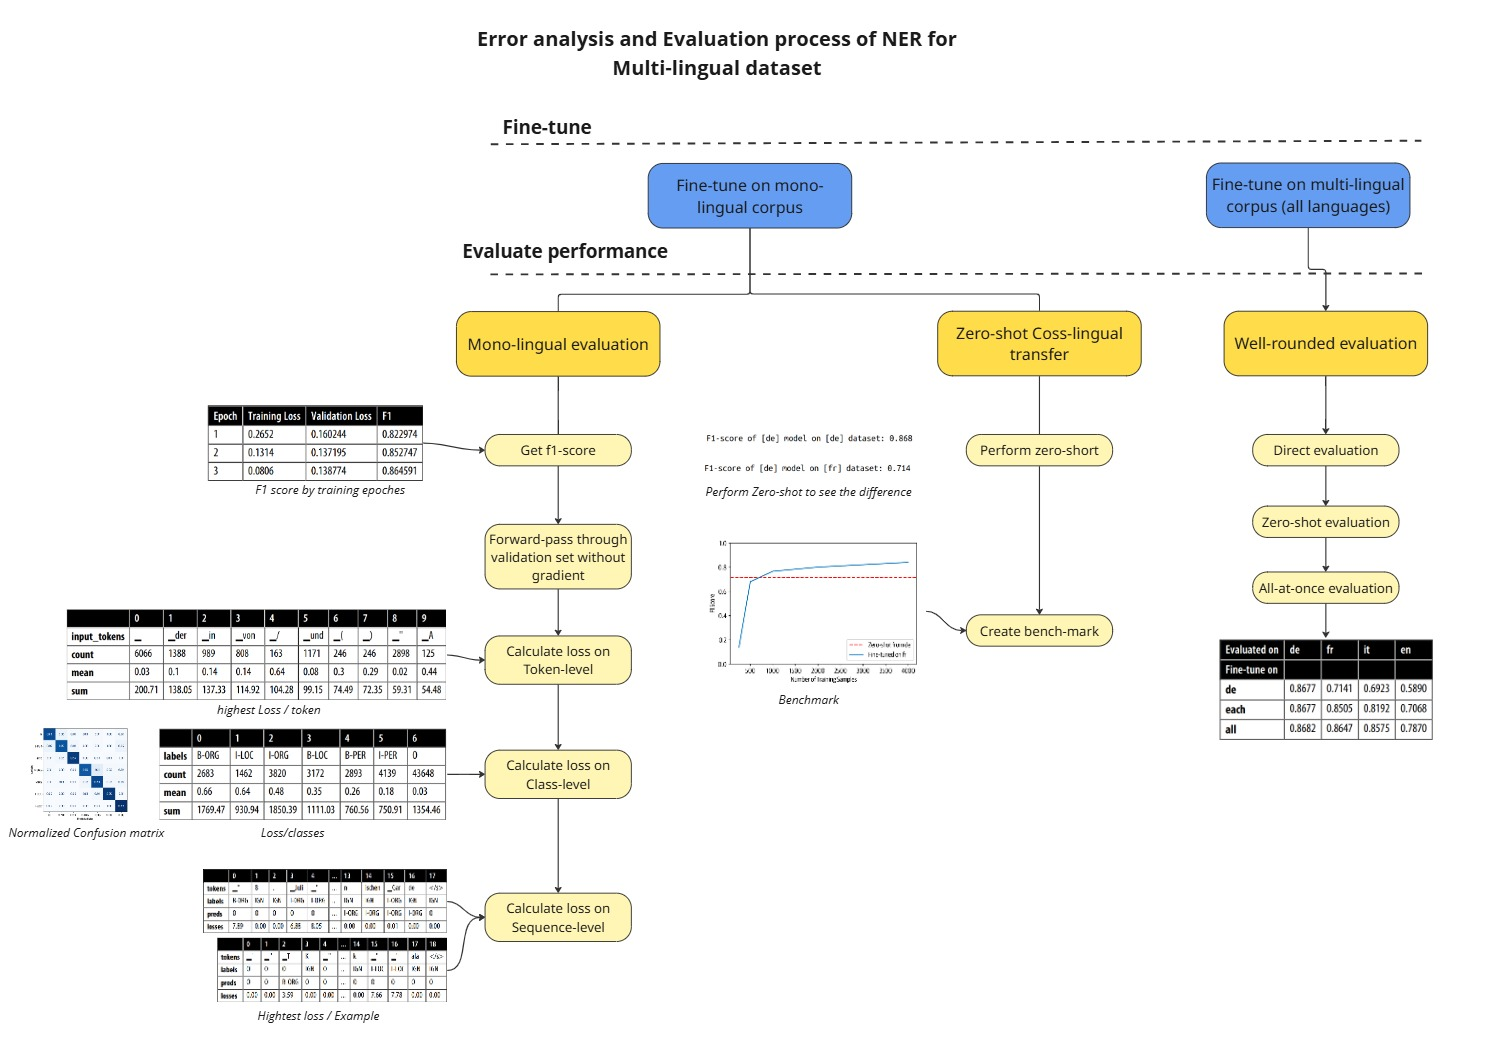

In [ ]:
import numpy as np
from torch.nn.functional import cross_entropy


example = torch.tensor(panx_de_encoded['train'][0]['input_ids']).to(device).unsqueeze(0) #unsqueeze to add dimension 1 -> 2
output = retrieved_model(example).logits
output.shape #batch_size x seq_len x num_label : 3d tensor
output.view(-1, 7).shape #-1 arguement automaitcally calculate batch_size x seq_len -> Flatten it into 2d tensor

label = torch.tensor(panx_de_encoded['train'][0]['labels']).to(device)
loss = cross_entropy(output.view(-1, 7).float(), label,  reduction = 'none')
loss.shape #Loss per token

torch.Size([25])

In [ ]:
panx_de_encoded['validation'][0]

{'input_ids': [0, 10699, 11, 15, 16104, 1388, 2],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1],
 'labels': [-100, 3, -100, 4, 4, 4, -100]}

***Note***: <br>Data_collator, which is responsible for padding the tensors to the largest example in a batch, requires the input data to be **list of dictionaries**. But our input data is **dictionary of lists**. Therefore, we need to transform it in our forward pass. <br>
But in trainer() call, it automatically handles it for us. Therefore we don't need to.

In [ ]:
#to see if our data is list of dictionaries:
panx_de_encoded['validation'][:2]
#This structure store the example following each keys

{'input_ids': [[0, 10699, 11, 15, 16104, 1388, 2],
  [0,
   56530,
   25216,
   30121,
   152385,
   19229,
   83982,
   1002,
   170,
   10,
   434,
   188,
   31721,
   299,
   170,
   57,
   15263,
   2]],
 'attention_mask': [[1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'labels': [[-100, 3, -100, 4, 4, 4, -100],
  [-100,
   0,
   -100,
   -100,
   -100,
   -100,
   3,
   -100,
   -100,
   4,
   -100,
   -100,
   -100,
   -100,
   -100,
   4,
   -100,
   -100]]}

In [ ]:
batch = panx_de_encoded['validation'][:2]
batch.values() #retrieve the values following each key (input_ids), (attention_mask), (labels)
zip(*batch.values()) #pair-up element across each list for every example

In [ ]:
def forward_with_label(batch, model):
  #Convert dict of lists to list of dicts
  features = [dict(zip(batch, t)) for t in zip(*batch.values())]
  #Pad inputs and labels in to 1 tensor device
  batch = data_collator(features)
  input_ids = batch['input_ids'].to(device)
  labels = batch['labels'].to(device)
  attention_masks = batch['attention_mask'].to(device)

  with torch.no_grad():
    outputs = model(input_ids = input_ids,
                    attention_masks = attention_masks) #(batch_size, seq_len, num_label)
    #get predicted label
    predicted_label = torch.argmax(outputs, axis = -1).cpu().numpy()

    #calculate foward_pass loss-per-token after flattening batch dimension
    loss = cross_entropy(outputs.view(-1, 7).float(), #(batch_size x seq_len, num_label)
                         labels.view(-1), #(batch_size, seq_len)
                         reduction = 'none')

    #Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss": loss, "predicted_label": predicted_label}